In [1]:
from os.path import join,expanduser
import sys
import cmocean as cmo
# identify user's home directory
user_home_dir = expanduser('~')
# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import botocore
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
from matplotlib import colors as mcolors
from matplotlib.cm import ScalarMappable
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr
import pandas as pd



In [2]:
# ====         1. EXtract W velocity   ======
## Open the ECCO grid files
grid_dir  = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/geometry/')
ds_grid   = xr.open_dataset(grid_dir / 'GRID_GEOMETRY_ECCO_V4r5_native_llc0090.nc')

## Open the monthly temperature-salinity files
directory = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_VELOCITY')
# list sub-directories (one per dataset) 1992 - 2019
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(directory.glob('*')))

## Organise t data into 12 (month) folders, each of them containing OHC throughout 1992-2019:
W         = [[] for _ in range(12)]
for i, file_path in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):##loops throughout the 336 monthly files 1992-2019
    ds        = xr.open_dataset(file_path)
    month_idx = int(ds.time.dt.month.item()) - 1 # Extract month (1–12), convert to index (0–11)
    w      = ds.WVEL
    W[month_idx].append(w)


In [3]:
##2. Do the climatology of W velocity

climon    = []
for i in range(0,12):
  print("I am in month",i)
  var     = W[i]
  mon_all = xr.concat(var, dim='time')
  monclim = mon_all.mean(dim='time',skipna="True")
  climon.append(monclim)




I am in month 0
I am in month 1
I am in month 2
I am in month 3
I am in month 4
I am in month 5
I am in month 6
I am in month 7
I am in month 8
I am in month 9
I am in month 10
I am in month 11


In [16]:
var = climon[a][0:6,:,:,:].mean(dim=["k_l"],skipna=True)

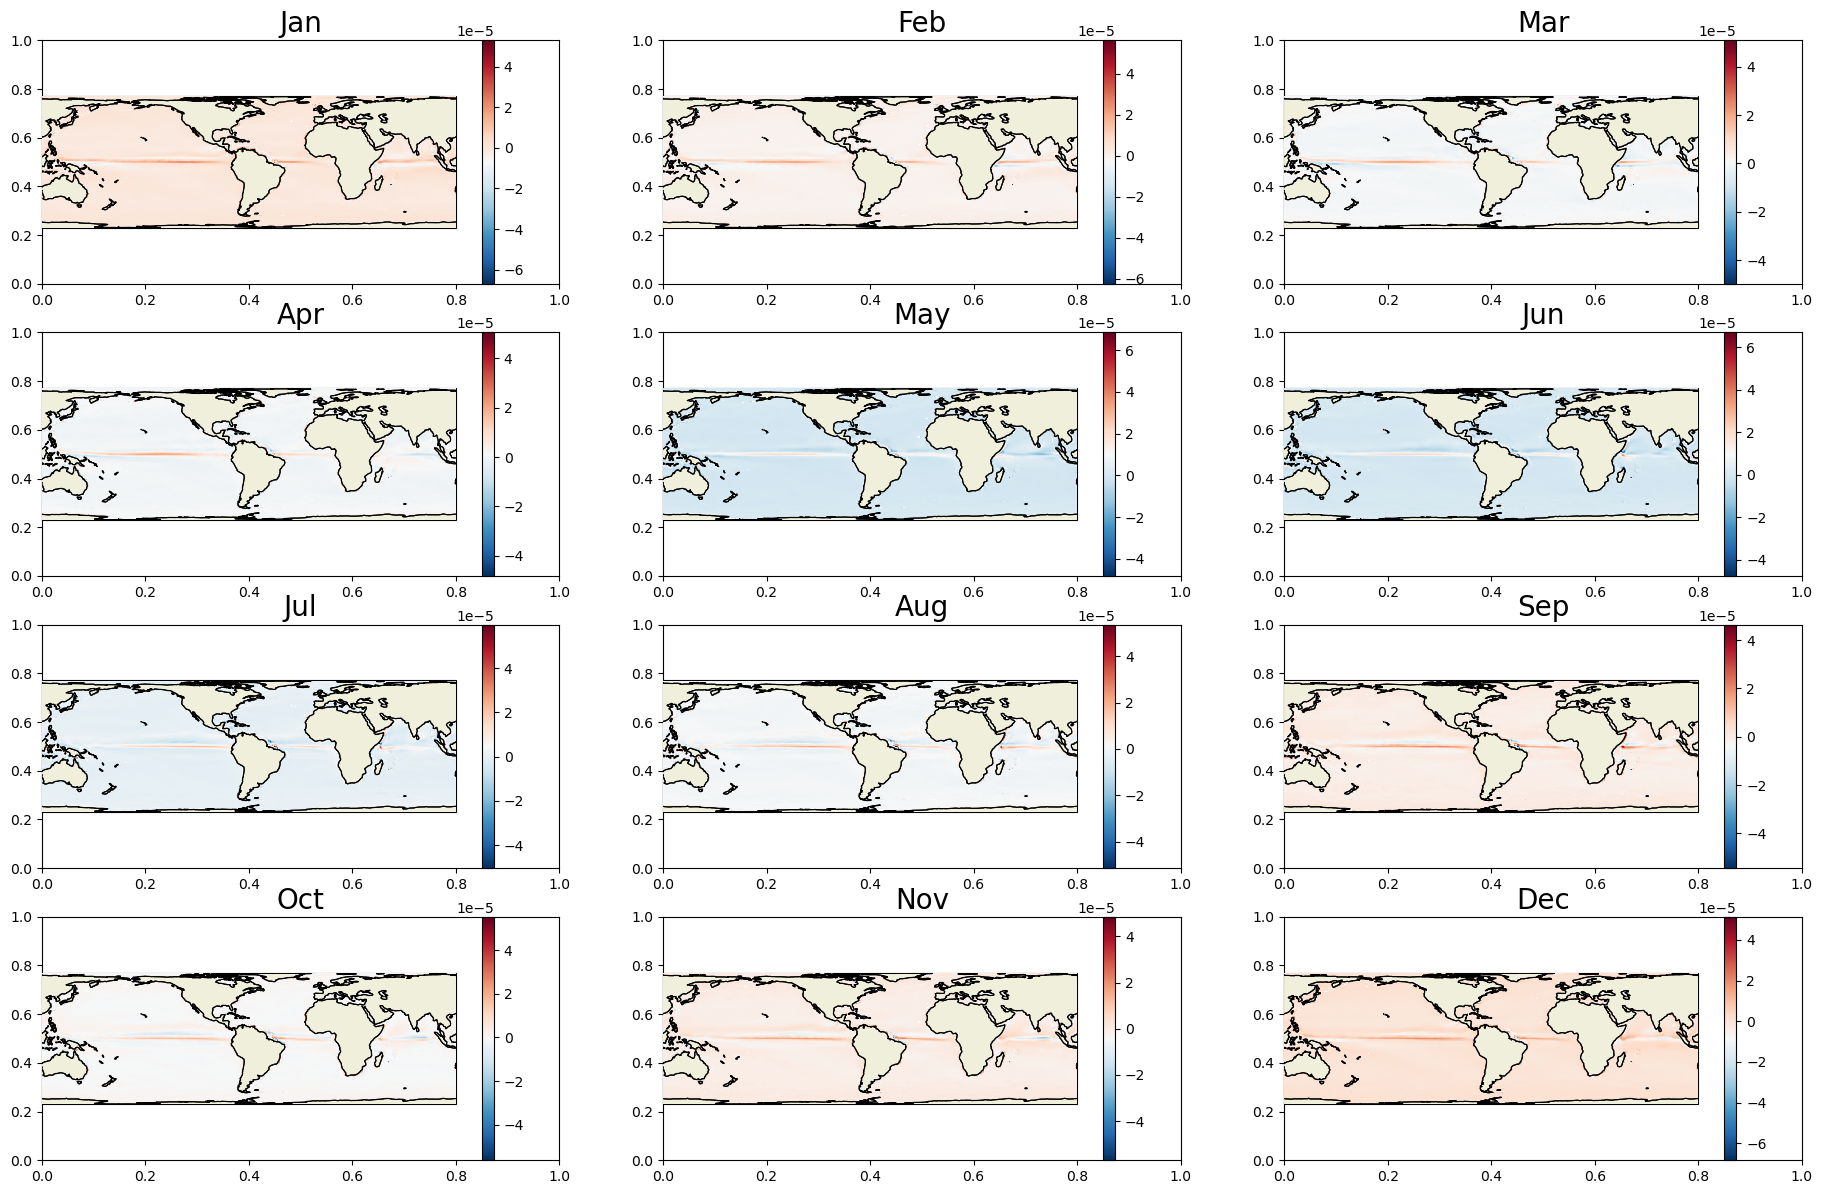

In [20]:
## ---------- PLOT the climatology of W here ---------------------------------
montitles = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
#cmin = -2;cmax=30;cstep=5
nrow      =4;ncol=3;figca      = []
colorm    = cmocean.cm.balance
fig, axs  = plt.subplots(nrow,ncol,figsize=(22,14))
plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.2)
axis      = fig.axes
for a in range(0,12):
  var = climon[a][0:6,:,:,:].mean(dim=["k_l"],skipna=True)
  ecco.plot_proj_to_latlon_grid(var.XC, var.YC, var,user_lon_0=-66,projection_type='cyl',plot_type = 'pcolormesh', dx=.25,dy=.25,colormap=colorm,show_coastline=True,subplot_grid=[nrow, ncol, a+1],show_colorbar=True)
  axis[a].set_title(montitles[a],fontsize=20)
